In [1]:
%pylab inline
from astropy.io import fits as pyfits
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from astropy.table import Table,Column
import scipy.stats.distributions as dist

import os
import warnings
import requests

mpl.rcParams['text.usetex']=True
mpl.rcParams['axes.linewidth'] = 3

warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=UserWarning, append=True);

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load data from Dropbox folder instead of clogging up Github

def download_from_dropbox(url):
    
    local_filename = "../{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename


In [3]:
p_spiral = 't04_spiral_a01_spiral_weighted_fraction'
p_clumpy = 't12_clumpy_a01_yes_weighted_fraction'
p_merger = 't08_odd_feature_a06_merger_weighted_fraction'
p_irregular= 't08_odd_feature_a04_irregular_weighted_fraction'
p_edgeon= 't02_edgeon_a01_yes_weighted_fraction'
N_spiral = 't04_spiral_total_weight'
N_clumpy = 't12_clumpy_total_weight'
N_odd = 't06_odd_a01_yes_weight'
N_edge = 't02_edgeon_total_weight'

In [4]:
# Load Data!
ferengi_filename = download_from_dropbox("https://www.dropbox.com/s/2dsnro4r5sa48gb/ferengi_all_weighted_and_meta.fits?dl=1")
data = Table.read(ferengi_filename) 

In [5]:
#Hubble Data:
hubble_data = pyfits.open('/home/mel/Documents/GZ_HUBBLE/other_catalogs/ULTRAVISTA/matched_catalog_12_04_15.fits')
hubble_data=hubble_data[1].data
z='Z_BEST_COMBINED'
data_2_1 = (hubble_data[z]>=.2) & (hubble_data[z]<=1) 
print 'The number of galaxies in COSMOS between $0.2 < z < 1.0$ is %s'%len(hubble_data[data_2_1])

#red_sequence = (hubble_data[z]>=0.2) & (hubble_data[z]<=1) & (hubble_data['MNUV']-hubble_data['MR']>(2.7-.077*hubble_data['MR'])) 
#blue_cloud = (hubble_data[z]>=0.2) & (hubble_data[z]<=1) & (hubble_data['MNUV']-hubble_data['MR']<(1.9-.077*hubble_data['MR'])) 

red_sequence = (hubble_data[z]>=0.2) & (hubble_data[z]<=1) & (hubble_data['MNUV']-hubble_data['MR']>3*(hubble_data['MR']-hubble_data['MJ'])+1) & (hubble_data['MNUV']-hubble_data['MR']>3.1) 
blue_cloud = (hubble_data[z]>=0.2) & (hubble_data[z]<=1) & ((hubble_data['MNUV']-hubble_data['MR']<3*(hubble_data['MR']-hubble_data['MJ'])+1) | (hubble_data['MNUV']-hubble_data['MR']<3.1)) 


print 'The number of red galaxies: %s'%len(hubble_data[red_sequence])
print 'The number of blue galaxies: %s'%len(hubble_data[blue_cloud])


The number of galaxies in COSMOS between $0.2 < z < 1.0$ is 52732
The number of red galaxies: 10015
The number of blue galaxies: 42717


In [6]:
yedges=np.linspace(np.min(data['mu_max_i']),np.max(data['mu_max_i']),7)
yedges=[round(y,2) for y in yedges]

xedges=np.linspace(np.min(data['sim_redshift'])-.1,np.max(data['sim_redshift']),5)
xedges=[round(x,2) for x in xedges]

#p_x = 't00_smooth_or_features_a1_features_frac_weighted_2' #p for question in question (lol)
p_x = 'p_features_best'
N_x = 't00_smooth_or_features_count_weighted_2' #N for question in question (number of people who answered question) 
N_cut = 0 #number of people we require to get to question

red_data = data[(data['PETROMAG_U']-data['PETROMAG_R']<2)]
blue_data=data[(data['PETROMAG_U']-data['PETROMAG_R']>=2)]

#Pick out unique galaxies
galaxies = set(data['objid'])
red_galaxies = set(red_data['objid'])
blue_galaxies = set(blue_data['objid'])

In [7]:
xedges

[0.2, 0.4, 0.6, 0.8, 1.0]

In [8]:
red_scatter_dct={}
for i in range(0,len(xedges)-1):
    for j in range(0,len(yedges)-1):
        red_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'hi']=[]
        red_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'lo']=[]
        red_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'subj_id']=[]
        
red_scatter_dct_unc={}
for i in range(0,len(xedges)-1):
    for j in range(0,len(yedges)-1):
        red_scatter_dct_unc[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'hi']=[]
        red_scatter_dct_unc[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'lo']=[]
        red_scatter_dct_unc[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'subj_id']=[]

blue_scatter_dct={}
for i in range(0,len(xedges)-1):
    for j in range(0,len(yedges)-1):
        blue_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'hi']=[]
        blue_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'lo']=[]
        blue_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'subj_id']=[]

all_scatter_dct={}
for i in range(0,len(xedges)-1):
    for j in range(0,len(yedges)-1):
        all_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'hi']=[]
        all_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'lo']=[]
        all_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'subj_id']=[]

all_scatter_dct_unc={}
for i in range(0,len(xedges)-1):
    for j in range(0,len(yedges)-1):
        all_scatter_dct_unc[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'hi']=[]
        all_scatter_dct_unc[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'lo']=[]
        all_scatter_dct_unc[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'subj_id']=[]

red_fractions_dct={}


In [9]:
p_x = 'p_features_best'


for i,g in enumerate(red_galaxies):
    this_gal=(red_data['objid']==g)
    evos = set(red_data[this_gal]['sim_evolution'])
    for e in evos:
        this_evo=(red_data[this_gal]['sim_evolution']==e)
        if round(np.min(list((set(red_data[this_gal][this_evo]['sim_redshift'])))),2)==0.3: #only want stuff where we have data down to 0.3
            p_at_3=(red_data[this_gal][this_evo]['sim_redshift']==.3)
            p_x_at_3 = red_data[this_gal][this_evo][p_at_3][p_x][0]#value of p_x at redshift 0.3
            n_x_at_3 = red_data[this_gal][this_evo][p_at_3][N_x][0] #number of people who answeredquestion for the 0.3 image
            if n_x_at_3 >= N_cut: #only care about galaxies with at least N people answering question at 0.3
                for row in red_data[this_gal][this_evo]:
                    for y in range(0,len(yedges)-1):
                        for x in range(0,len(xedges)-1):
                            if row['sim_redshift']>xedges[x] and row['sim_redshift'] < xedges[x+1] and row['mu_max_i'] > yedges[y] and row['mu_max_i'] < yedges[y+1] and row[N_x]>=N_cut: #now look at high redshift data ; only care if 5 people answerwed question
                                if row['Correctable_Category']=='correctable  ':
                                    red_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi'].append(row[p_x]) # slap p_x in high list 
                                    red_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo'].append(p_x_at_3) # put z=0.3 value in low list 
                                else:
                                    red_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi'].append(row[p_x]) # slap p_x in high list 
                                    red_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo'].append(p_x_at_3) # put z=0.3 value in low list 

                                
for i,g in enumerate(galaxies):
    this_gal=(data['objid']==g)
    evos = set(data[this_gal]['sim_evolution'])
    for e in evos:
        this_evo=(data[this_gal]['sim_evolution']==e)
        if round(np.min(list((set(data[this_gal][this_evo]['sim_redshift'])))),2)==0.3: #only want stuff where we have data down to 0.3
            p_at_3=(data[this_gal][this_evo]['sim_redshift']==.3)
            p_x_at_3 = data[this_gal][this_evo][p_at_3][p_x][0]#value of p_x at redshift 0.3
            n_x_at_3 = data[this_gal][this_evo][p_at_3][N_x][0] #number of people who answeredquestion for the 0.3 image
            if n_x_at_3 >= N_cut: #only care about galaxies with at least N people answering question at 0.3
                for row in data[this_gal][this_evo]:
                    for y in range(0,len(yedges)-1):
                        for x in range(0,len(xedges)-1):
                            if row['sim_redshift']>xedges[x] and row['sim_redshift'] < xedges[x+1] and row['mu_max_i'] > yedges[y] and row['mu_max_i'] < yedges[y+1] and row[N_x]>=N_cut: #now look at high redshift data ; only care if 5 people answerwed question
                                if row['Correctable_Category']=='correctable  ':
                                    all_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi'].append(row[p_x]) # slap p_x in high list 
                                    all_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo'].append(p_x_at_3) # put z=0.3 value in low list 
                                else:
                                    all_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi'].append(row[p_x]) # slap p_x in high list 
                                    all_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo'].append(p_x_at_3) # put z=0.3 value in low list 


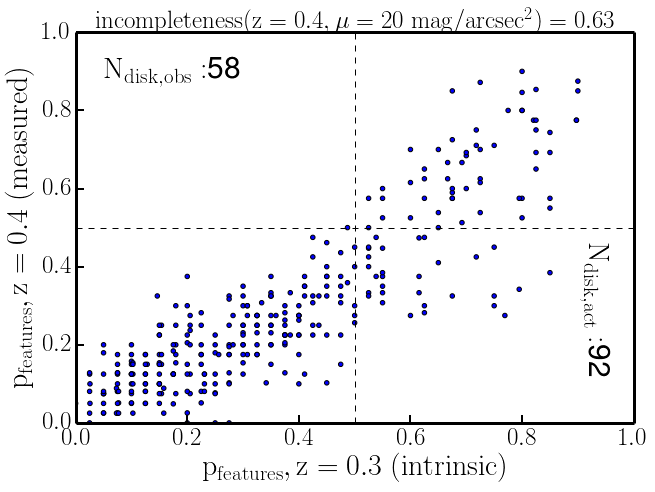

In [60]:
#plot one square of completeness plot 

mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25 

disk_cut=.5
f=plt.figure(figsize=(10,7))
x=1
y=2
xs=all_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
ys=all_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']
xs_unc=all_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
ys_unc=all_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']

plt.axhline(disk_cut,ls='dashed',c='k')
plt.axvline(disk_cut,ls='dashed',c='k')
#calculate number of observed disks
disks_observed = sum(i>=disk_cut for i in ys) + sum(i>=disk_cut for i in ys_unc)
disks_actual = sum(i>=disk_cut for i in xs) + sum(i>=disk_cut for i in xs_unc)
i_factor = round(float(disks_observed)/disks_actual,2)
plt.text(.05,.87,'$\mathrm{N_{disk,obs}:}$%s'%disks_observed,fontsize=30)
plt.text(.9,.4,'$\mathrm{N_{disk,act}:}$%s'%disks_actual,rotation=270,fontsize=30)
plt.tick_params(top='off',right='off')
plt.scatter(xs,ys)
plt.scatter(xs_unc,ys_unc)

plt.ylabel('$\mathrm{p_{features},z=0.4~(measured)}$',fontsize=30)
plt.xlabel('$\mathrm{p_{features},z=0.3~(intrinsic)}$',fontsize=30)
plt.title('$\mathrm{FERENGI}$\n$\mathrm{incompleteness(z=0.4,\mu=20~mag/arcsec^2)=%s}$'%i_factor,fontsize=18)
plt.title('$\mathrm{incompleteness(z=0.4,\mu=20~mag/arcsec^2)=%s}$'%i_factor,fontsize=25)

#plt.text(.5,.95,'$\mathrm{FERENGI\nincompleteness(z=0.4,\mu=20~mag/arcsec^2)=0.51}$',fontsize=25,ha='center')

plt.xlim(0,1)
plt.ylim(0,1)

plt.savefig('Poster_Images/no_labels/ferengi_incompleteness_one_square.eps',format='eps',dpi=1000)

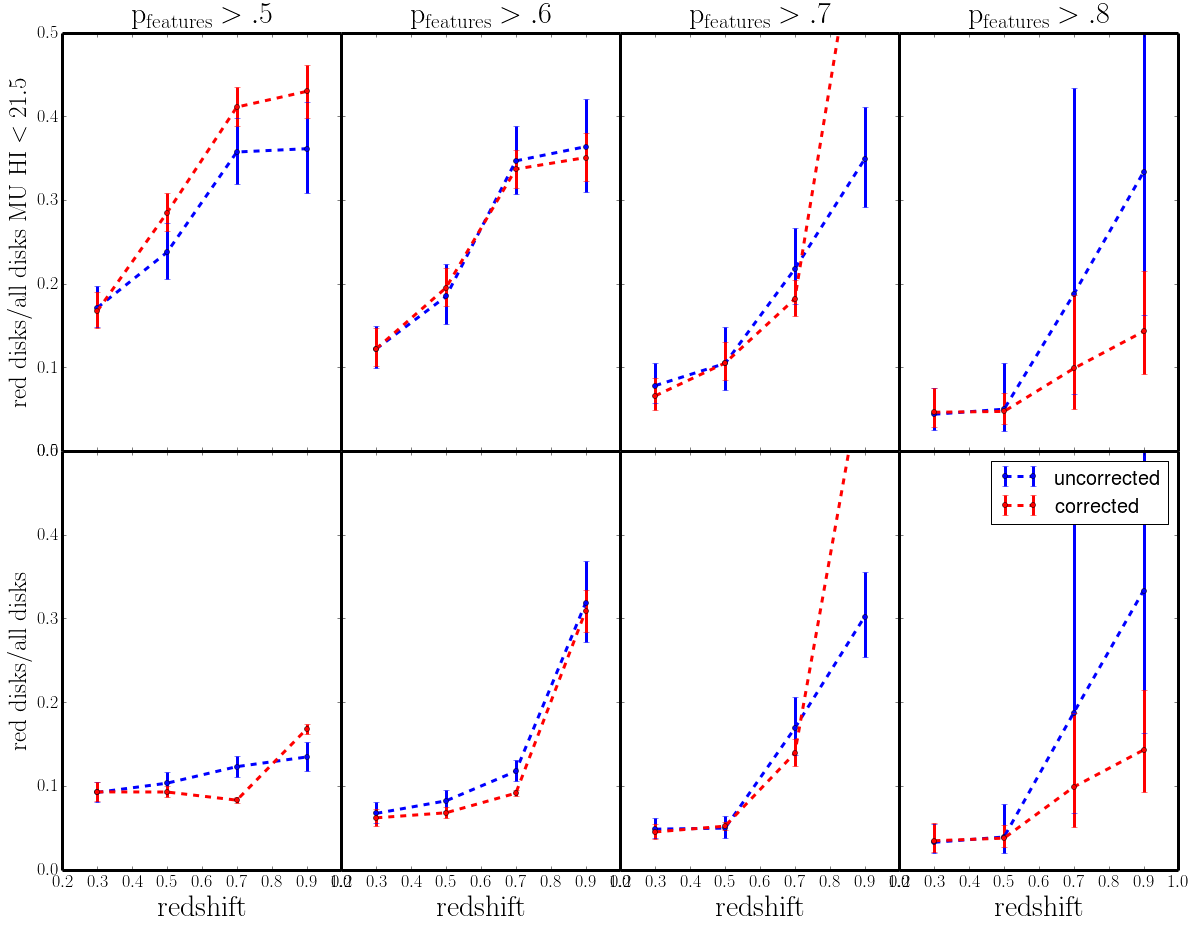

In [437]:


fig=figure(figsize=(20,15))
gs=gridspec.GridSpec(2,4)
gs.update(wspace=0)
gs.update(hspace=0)


ax1 = plt.subplot(gs[0,0])

dc=.5
sb=21.5

plt.errorbar(reds,red_fractions_dct[dc,sb][0]['fraction'],yerr=(red_fractions_dct[dc,sb][0]['err_lo'],red_fractions_dct[dc,sb][0]['err_hi']),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,red_fractions_dct[dc,sb][0]['fraction_corrected'],yerr=(red_fractions_dct[dc,sb][0]['err_lo_corrected'],red_fractions_dct[dc,sb][0]['err_hi_corrected']),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.ylabel('$\mathrm{red~disks/all~disks~MU~HI<%s}$'%sb,fontsize=25)
plt.tick_params(labelbottom='off')
plt.title('$\mathrm{p_{features}>.5}$',fontsize=30)
plt.xlim(.2,1)
plt.ylim(0,.5)

plt.subplot(gs[0,1],sharey=ax1)

dc=.6
sb=21.5

plt.errorbar(reds,red_fractions_dct[dc,sb][0]['fraction'],yerr=(red_fractions_dct[dc,sb][0]['err_lo'],red_fractions_dct[dc,sb][0]['err_hi']),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,red_fractions_dct[dc,sb][0]['fraction_corrected'],yerr=(red_fractions_dct[dc,sb][0]['err_lo_corrected'],red_fractions_dct[dc,sb][0]['err_hi_corrected']),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.tick_params(labelleft='off',labelbottom='off')
plt.title('$\mathrm{p_{features}>.6}$',fontsize=30)
plt.xlim(.2,1)
plt.ylim(0,.5)

plt.subplot(gs[0,2],sharey=ax1)

dc=.7
sb=21.5

plt.errorbar(reds,red_fractions_dct[dc,sb][0]['fraction'],yerr=(red_fractions_dct[dc,sb][0]['err_lo'],red_fractions_dct[dc,sb][0]['err_hi']),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,red_fractions_dct[dc,sb][0]['fraction_corrected'],yerr=(red_fractions_dct[dc,sb][0]['err_lo_corrected'],red_fractions_dct[dc,sb][0]['err_hi_corrected']),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.tick_params(labelleft='off',labelbottom='off')
plt.title('$\mathrm{p_{features}>.7}$',fontsize=30)
plt.xlim(.2,1)
plt.ylim(0,.5)


plt.subplot(gs[0,3],sharey=ax1)

dc=.8
sb=21.5

plt.errorbar(reds,red_fractions_dct[dc,sb][0]['fraction'],yerr=(red_fractions_dct[dc,sb][0]['err_lo'],red_fractions_dct[dc,sb][0]['err_hi']),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,red_fractions_dct[dc,sb][0]['fraction_corrected'],yerr=(red_fractions_dct[dc,sb][0]['err_lo_corrected'],red_fractions_dct[dc,sb][0]['err_hi_corrected']),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.tick_params(labelleft='off',labelbottom='off')
plt.title('$\mathrm{p_{features}>.8}$',fontsize=30)
plt.xlim(.2,1)
plt.ylim(0,.5)



ax2 = plt.subplot(gs[1,0])

dc=.5
sb=30

plt.errorbar(reds,red_fractions_dct[dc,sb][0]['fraction'],yerr=(red_fractions_dct[dc,sb][0]['err_lo'],red_fractions_dct[dc,sb][0]['err_hi']),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,red_fractions_dct[dc,sb][0]['fraction_corrected'],yerr=(red_fractions_dct[dc,sb][0]['err_lo_corrected'],red_fractions_dct[dc,sb][0]['err_hi_corrected']),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.xlabel('$\mathrm{redshift}$',fontsize=30)
plt.ylabel('$\mathrm{red~disks/all~disks}$',fontsize=25)
plt.xlim(.2,1)
plt.ylim(0,.5)

plt.subplot(gs[1,1],sharey=ax2)

dc=.6
sb=30

plt.errorbar(reds,red_fractions_dct[dc,sb][0]['fraction'],yerr=(red_fractions_dct[dc,sb][0]['err_lo'],red_fractions_dct[dc,sb][0]['err_hi']),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,red_fractions_dct[dc,sb][0]['fraction_corrected'],yerr=(red_fractions_dct[dc,sb][0]['err_lo_corrected'],red_fractions_dct[dc,sb][0]['err_hi_corrected']),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.xlabel('$\mathrm{redshift}$',fontsize=30)
plt.tick_params(labelleft='off')
plt.xlim(.2,1)
plt.ylim(0,.5)


plt.subplot(gs[1,2],sharey=ax2)

dc=.7
sb=30

plt.errorbar(reds,red_fractions_dct[dc,sb][0]['fraction'],yerr=(red_fractions_dct[dc,sb][0]['err_lo'],red_fractions_dct[dc,sb][0]['err_hi']),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,red_fractions_dct[dc,sb][0]['fraction_corrected'],yerr=(red_fractions_dct[dc,sb][0]['err_lo_corrected'],red_fractions_dct[dc,sb][0]['err_hi_corrected']),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.xlabel('$\mathrm{redshift}$',fontsize=30)
plt.tick_params(labelleft='off')
plt.xlim(.2,1)
plt.ylim(0,.5)


plt.subplot(gs[1,3],sharey=ax2)

dc=.8
sb=30

plt.errorbar(reds,red_fractions_dct[dc,sb][0]['fraction'],yerr=(red_fractions_dct[dc,sb][0]['err_lo'],red_fractions_dct[dc,sb][0]['err_hi']),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,red_fractions_dct[dc,sb][0]['fraction_corrected'],yerr=(red_fractions_dct[dc,sb][0]['err_lo_corrected'],red_fractions_dct[dc,sb][0]['err_hi_corrected']),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.xlabel('$\mathrm{redshift}$',fontsize=30)
plt.tick_params(labelleft='off')
plt.legend(fontsize=20)
plt.xlim(.2,1)
plt.ylim(0,.5)

plt.savefig('Images/red_disk_fraction_best_p_features.png')


## Set p_cut and SB cut and run all below to generate new red disk fraction vs redshift plot

In [12]:
disk_cut = .5
sb_cut=21.5
SB_cut = (hubble_data['MU_HI']<sb_cut)
p_edge_cut=(hubble_data[p_edgeon]<.6)

reds=[.3,.5,.7,.9]


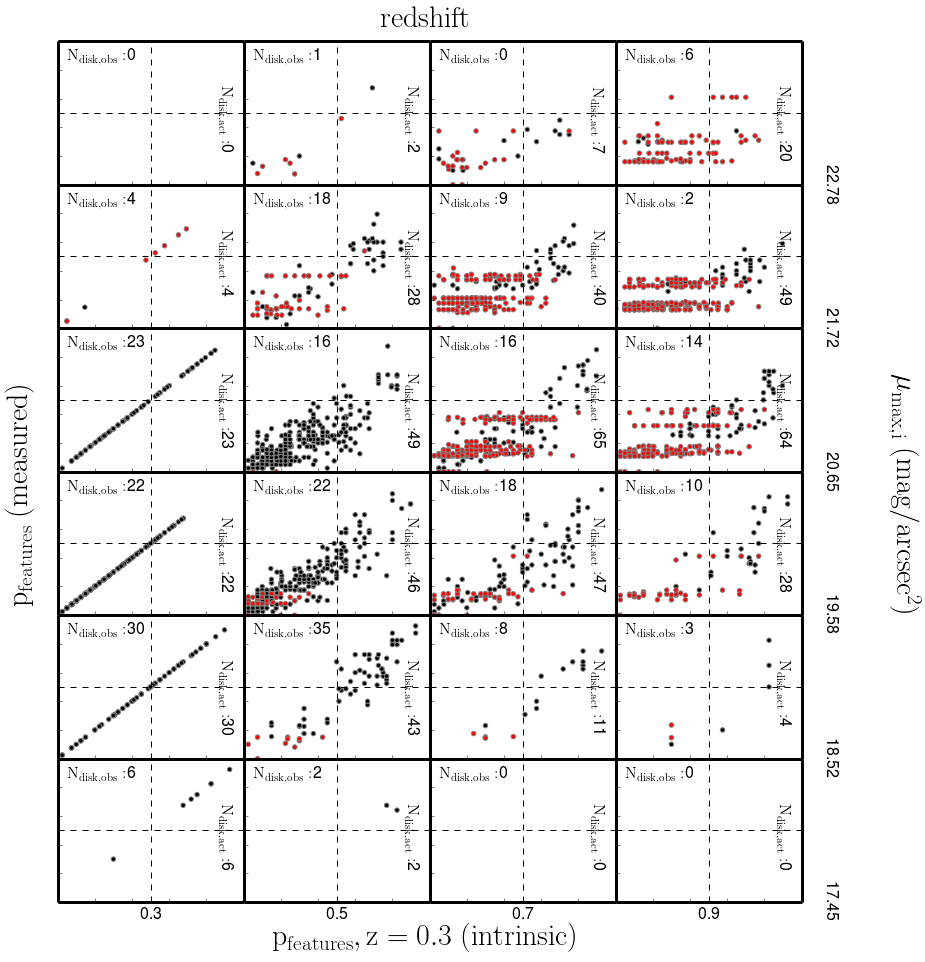

In [28]:
f=figure(figsize=(20,18))
#track 'uncorrectable' regions of z/mu/p space (shaded)
p_range_uncorrectable_dct={}
#track 'correctable regions of z/mu/p space (unshaded *and* at least 5 points in bin) 
p_range_correctable_dct={}
#store range of spread of data in each bin
interval_dct={}
x_new = np.linspace(0,.95,40)
slope_cut=.35

red_completion_matrix = np.zeros(shape=(len(xedges)-1,len(yedges)-1))

gs=gridspec.GridSpec(len(yedges),len(xedges)+1)
gs.update(wspace=0)
gs.update(hspace=0)
yedge_int=np.linspace(0,len(yedges)-2,len(yedges)-1)
yedge_int=[int(y) for y in yedge_int]
yedge_int=yedge_int[::-1]
x_label=[]
facecolors=['#af8dc3','#999999','#7fbf7b']
for i in range(0,len(xedges)-1):
    x_label.append(round((xedges[i]+xedges[i+1])/2,2))

for y in range(0,len(yedges)-1):
    for x in range(0,len(xedges)-1):
        ax=plt.subplot(gs[yedge_int[y],x])
        xs=red_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
        ys=red_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']
        xs_unc=red_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
        ys_unc=red_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']

        plt.axhline(disk_cut,ls='dashed',c='k')
        plt.axvline(disk_cut,ls='dashed',c='k')
        #calculate number of observed disks
        disks_observed = sum(i>=disk_cut for i in ys) + sum(i>=disk_cut for i in ys_unc)
        disks_actual = sum(i>=disk_cut for i in xs) + sum(i>=disk_cut for i in xs_unc)

        red_completion_matrix.T[y,x]=(float(disks_actual)/disks_observed) if len(xs)>10 and disks_observed > 0 else 'nan'

        
        ax.text(.05,.85,'$\mathrm{N_{disk,obs}:}$%s'%disks_observed,fontsize=16)
        ax.text(.85,.6,'$\mathrm{N_{disk,act}:}$%s'%disks_actual,rotation=270,fontsize=16)
        flat_list=[]
        plt.scatter(xs,ys,c='k',edgecolors='gray')
        plt.scatter(xs_unc,ys_unc,c='r',edgecolors='gray')

        plt.tick_params(labelleft='off')
        plt.tick_params(top='off',right='off',labelbottom='off')
        plt.xlim(0,1)
        plt.ylim(0,1)
        if y==0:
            plt.xlabel('%s'%str(x_label[x]),fontsize=16)

        if x==3:
            ax.yaxis.set_label_position("right")
            plt.ylabel('%s'%str(yedges[y]),fontsize=16,rotation=270)
            ax.yaxis.set_label_coords(1.2, 0)
    


f.text(.7,.55,r'$\mathrm{\mu_{max,i}~(mag/arcsec^2)}$',rotation=270,fontsize=30,va='center')
f.text(.38,.91,r'$\mathrm{redshift}$',fontsize=30,ha='center')
f.text(.09,.55,r'$\mathrm{p_{features}~(measured)}$',rotation=90,fontsize=30,va='center')
f.text(.38,.2,r'$\mathrm{p_{features},z=0.3~(intrinsic)}$',fontsize=30,ha='center')

#plt.savefig('Images/red_ferengi_corrected_debiased.png')



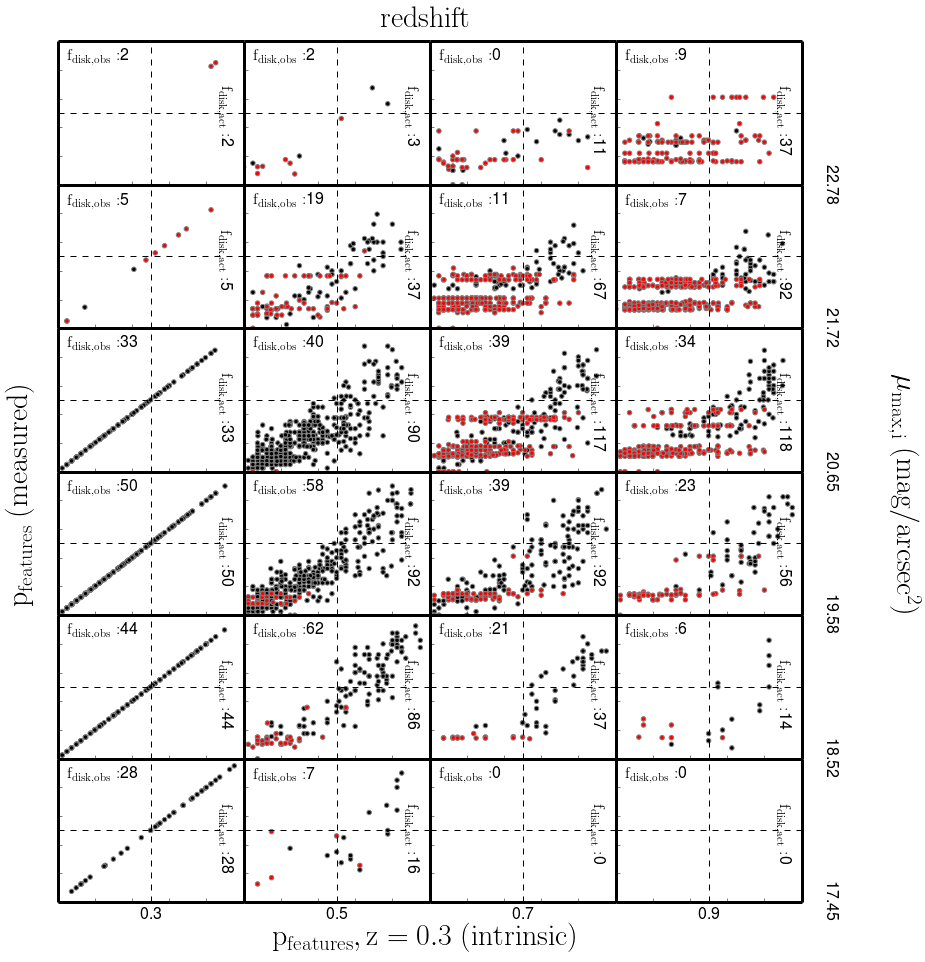

In [29]:
f=figure(figsize=(20,18))
interval_dct={}
x_new = np.linspace(0,.95,40)
slope_cut=.35

all_completion_matrix = np.zeros(shape=(len(xedges)-1,len(yedges)-1))

gs=gridspec.GridSpec(len(yedges),len(xedges)+1)
gs.update(wspace=0)
gs.update(hspace=0)
yedge_int=np.linspace(0,len(yedges)-2,len(yedges)-1)
yedge_int=[int(y) for y in yedge_int]
yedge_int=yedge_int[::-1]
x_label=[]
facecolors=['#af8dc3','#999999','#7fbf7b']
for i in range(0,len(xedges)-1):
    x_label.append(round((xedges[i]+xedges[i+1])/2,2))

for y in range(0,len(yedges)-1):
    for x in range(0,len(xedges)-1):
        ax=plt.subplot(gs[yedge_int[y],x])
        xs=all_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
        ys=all_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']
        xs_unc=all_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
        ys_unc=all_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']

        
        plt.axhline(disk_cut,ls='dashed',c='k')
        plt.axvline(disk_cut,ls='dashed',c='k')
        #calculate number of observed disks
        disks_observed = sum(i>=disk_cut for i in ys) + sum(i>=disk_cut for i in ys_unc)
        disks_actual = sum(i>=disk_cut for i in xs) + sum(i>=disk_cut for i in xs_unc)
        all_completion_matrix.T[y,x]=(float(disks_actual)/disks_observed) if len(xs)>10 and disks_observed > 0 else 'nan'

        
        ax.text(.05,.85,'$\mathrm{f_{disk,obs}:}$%s'%disks_observed,fontsize=16)
        ax.text(.85,.6,'$\mathrm{f_{disk,act}:}$%s'%disks_actual,rotation=270,fontsize=16)
        flat_list=[]
        plt.scatter(xs,ys,c='k',edgecolors='gray')
        plt.scatter(xs_unc,ys_unc,c='r',edgecolors='gray')

        plt.tick_params(labelleft='off')
        plt.tick_params(top='off',right='off',labelbottom='off')
        plt.xlim(0,1)
        plt.ylim(0,1)
        if y==0:
            plt.xlabel('%s'%str(x_label[x]),fontsize=16)

        if x==3:
            ax.yaxis.set_label_position("right")
            plt.ylabel('%s'%str(yedges[y]),fontsize=16,rotation=270)
            ax.yaxis.set_label_coords(1.2, 0)
  
                


f.text(.7,.55,r'$\mathrm{\mu_{max,i}~(mag/arcsec^2)}$',rotation=270,fontsize=30,va='center')
f.text(.38,.91,r'$\mathrm{redshift}$',fontsize=30,ha='center')
f.text(.09,.55,r'$\mathrm{p_{features}~(measured)}$',rotation=90,fontsize=30,va='center')
f.text(.38,.2,r'$\mathrm{p_{features},z=0.3~(intrinsic)}$',fontsize=30,ha='center')

#plt.savefig('Images/all_ferengi_corrected_debiased.png')


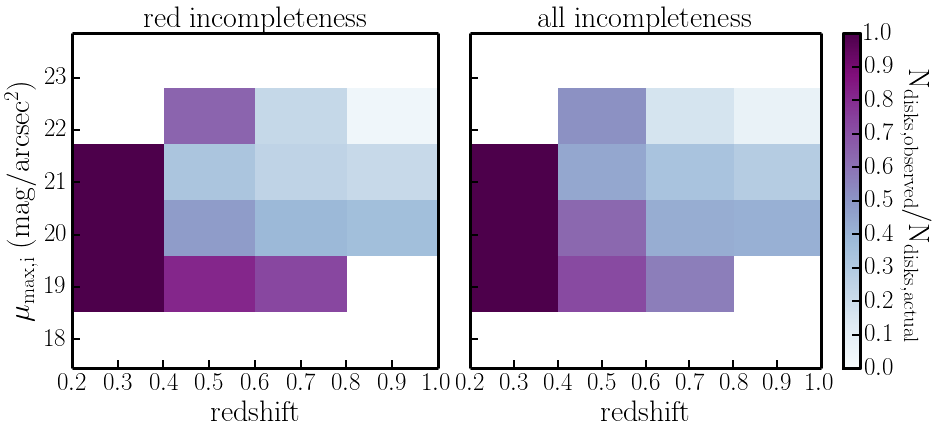

In [58]:
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]

mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.major.width'] = 2

cmap=cm.BuPu
f=figure(figsize=(15,6))

mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25 

gs=gridspec.GridSpec(1,2,width_ratios=[1,1.2])
gs.update(wspace=.08)

redax=plt.subplot(gs[0,0])
plt.imshow(1./red_completion_matrix.T,origin='lower',interpolation='nearest',vmin=0,vmax=1,extent=extent,aspect='auto',cmap=cmap)
plt.tick_params(top='off',right='off')
plt.title('$\mathrm{red~incompleteness}$',fontsize=30)
plt.xlabel('$\mathrm{redshift}$',fontsize=30)

plt.ylabel(r'$\mathrm{\mu_{max,i}~(mag/arcsec^2)}$',fontsize=30)

all_completion_matrix=np.ma.array(all_completion_matrix,mask=np.isnan(1./red_completion_matrix)==True)


blueax=plt.subplot(gs[0,1])
plt.imshow(1./all_completion_matrix.T,origin='lower',interpolation='nearest',vmin=0,vmax=1,extent=extent,aspect='auto',cmap=cmap)
plt.colorbar()
plt.tick_params(labelleft='off',top='off',right='off')

plt.title('$\mathrm{all~incompleteness}$',fontsize=30)
plt.xlabel('$\mathrm{redshift}$',fontsize=30)

f.text(.89,.5,r'$\mathrm{N_{disks,observed}/N_{disks,actual}}$',rotation=270,fontsize=30,va='center')

plt.savefig('Poster_Images/incompleteness_plots.eps',format='eps',dpi=1000)


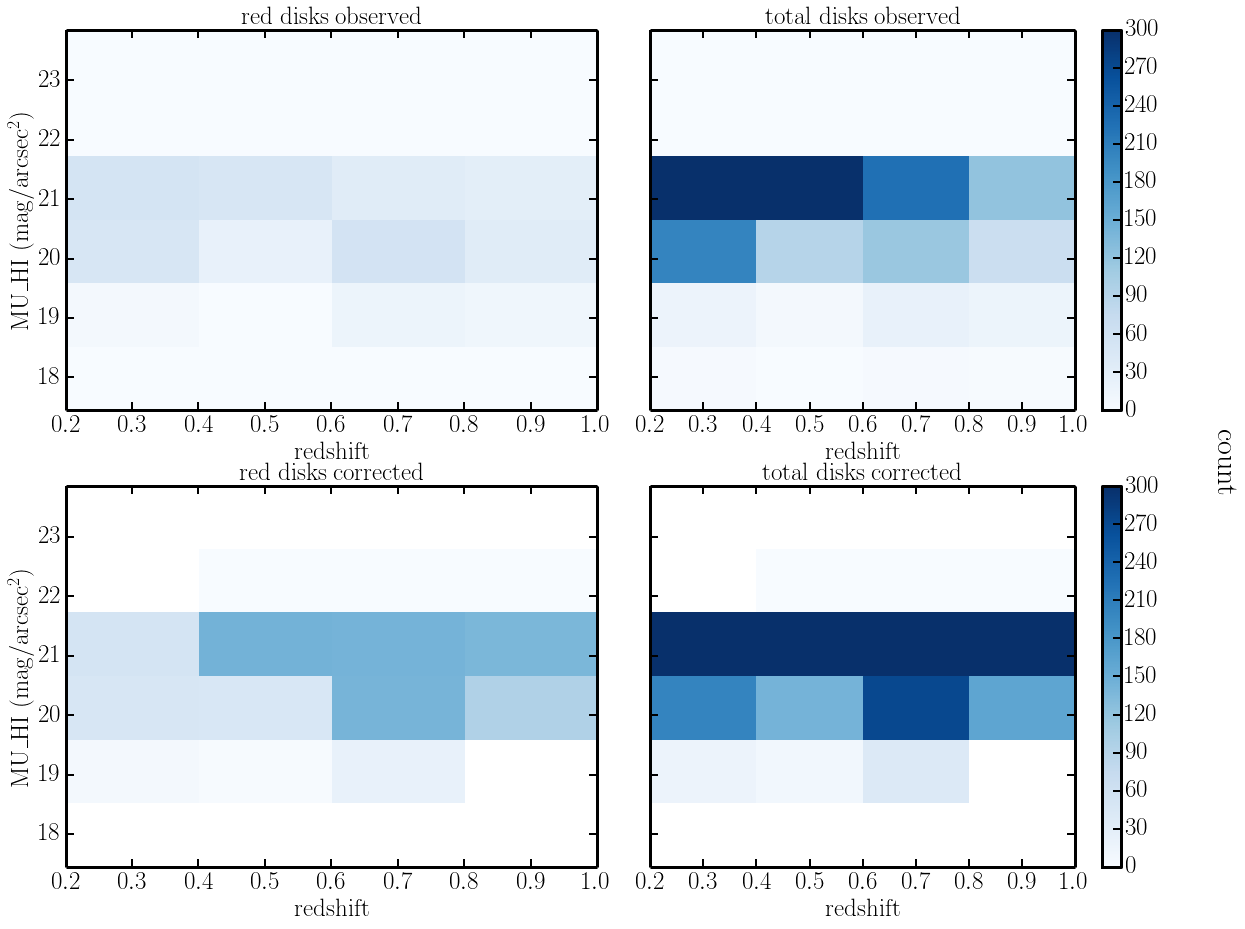

In [86]:
xlabel = '$\mathrm{redshift}$'
ylabel = '$\mathrm{MU\_HI~(mag/arcsec^2)}$'

red_disks = red_sequence & SB_cut & (hubble_data['t01_smooth_or_features_a02_features_or_disk_best_fraction']>=disk_cut) & (hubble_data[z]>=xedges[0]) & (hubble_data[z] <= xedges[-1]) & (hubble_data[N_edge]>=5) & p_edge_cut 
blue_disks = blue_cloud & SB_cut & (hubble_data['t01_smooth_or_features_a02_features_or_disk_best_fraction']>=disk_cut) & (hubble_data[z]>=xedges[0]) & (hubble_data[z] <= xedges[-1]) & (hubble_data[N_edge]>=5) & p_edge_cut
all_disks = SB_cut & (hubble_data['t01_smooth_or_features_a02_features_or_disk_best_fraction']>=disk_cut) & (hubble_data[z]>=xedges[0]) & (hubble_data[z] <= xedges[-1]) & (hubble_data[N_edge]>=5) & p_edge_cut

vmin=0
vmax=300

f=figure(figsize=(20,15))
gs=gridspec.GridSpec(2,2)
gs.update(wspace=.1)
gs.update(hspace=.2)

red_hist,xedges1,yedges1=np.histogram2d(hubble_data[red_disks][z],hubble_data[red_disks]['MU_HI'],range=((xedges[0],xedges[-1]),(yedges[0],yedges[-1])),bins=(len(xedges)-1,len(yedges)-1))
all_hist,xedges1,yedges1=np.histogram2d(hubble_data[all_disks][z],hubble_data[all_disks]['MU_HI'],range=((xedges[0],xedges[-1]),(yedges[0],yedges[-1])),bins=(len(xedges)-1,len(yedges)-1))
#red_hist=np.ma.array(red_hist,mask=np.isnan(red_completion_matrix)==True)
#all_hist=np.ma.array(all_hist,mask=np.isnan(red_completion_matrix)==True)


extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]]

redax=plt.subplot(gs[0,0])
plt.imshow(red_hist.T,origin='lower',interpolation='nearest',extent=extent,aspect='auto',cmap=cm.Blues,vmin=vmin,vmax=vmax)
plt.title('$\mathrm{red~disks~observed}$',fontsize=25)
plt.ylabel(ylabel,fontsize=25)
plt.xlabel(xlabel,fontsize=25)


allax=plt.subplot(gs[0,1])
plt.imshow(all_hist.T,origin='lower',interpolation='nearest',extent=extent,aspect='auto',cmap=cm.Blues,vmin=vmin,vmax=vmax)
plt.title('$\mathrm{total~disks~observed}$',fontsize=25)
plt.tick_params(labelleft='off')
plt.xlabel(xlabel,fontsize=25)
plt.colorbar()

corrected_red_matrix = red_hist*red_completion_matrix
corrected_all_matrix = all_hist*all_completion_matrix
corrected_all_matrix=np.ma.array(corrected_all_matrix,mask=np.isnan(red_completion_matrix)==True)



redax=plt.subplot(gs[1,0])
plt.imshow(corrected_red_matrix.T,origin='lower',interpolation='nearest',extent=extent,aspect='auto',cmap=cm.Blues,vmin=vmin,vmax=vmax)
plt.title('$\mathrm{red~disks~corrected}$',fontsize=25)
plt.ylabel(ylabel,fontsize=25)
plt.xlabel(xlabel,fontsize=25)


allax=plt.subplot(gs[1,1])
plt.imshow(corrected_all_matrix.T,origin='lower',interpolation='nearest',extent=extent,aspect='auto',cmap=cm.Blues,vmin=vmin,vmax=vmax)
plt.title('$\mathrm{total~disks~corrected}$',fontsize=25)
plt.tick_params(labelleft='off')
plt.xlabel(xlabel,fontsize=25)
plt.colorbar()


f.text(.92,.5,r'$\mathrm{count}$',rotation=270,fontsize=30,va='center')


In [87]:
def red_fraction_list(red_matrix,all_matrix):
    c=.95
    red_disk_fraction=[]
    N_red=[]
    N_all=[]
    yerr_low=[]
    yerr_hi=[]
    fraction_matrix = red_matrix/all_matrix
    for i in range(0,4):
        N_red_disks = np.nansum(red_matrix.T[:,i])
        N_all_disks = np.nansum(all_matrix.T[:,i])
        frac = N_red_disks/N_all_disks
        p_l=dist.beta.ppf((1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
        p_u=dist.beta.ppf(1-(1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
        yerr_low.append(frac-p_l)
        yerr_hi.append(p_u-frac)
        N_red.append(N_red_disks)
        N_all.append(N_all_disks)
        red_disk_fraction.append(frac)
    
    return red_disk_fraction,yerr_low,yerr_hi,N_red,N_all


In [88]:
red_fractions_dct[disk_cut,sb_cut]=[]

frac,yl,yh,Nr,Na=red_fraction_list(red_hist,all_hist)
frac=[round(val,2) for val in frac]

frac_c,yl_c,yh_c,Nr_c,Na_c=red_fraction_list(corrected_red_matrix,corrected_all_matrix)
frac_c=[round(val,2) for val in frac_c]
Nr_c=[int(val) for val in Nr_c]
Na_c=[int(val) for val in Na_c]
red_fractions_dct[disk_cut,sb_cut].append({'fraction':frac,'err_lo':yl,'err_hi':yh,'N_red':Nr,'N_all':Na,'fraction_corrected':frac_c,'err_lo_corrected':yl_c,'err_hi_corrected':yh_c,'N_red_corrected':Nr_c,'N_all_corrected':Na_c})

In [89]:
y1_c=[]
y2_c=[]
for i in range(0,len(frac_c)):
    y1_c.append(frac_c[i]-yl[i])
    y2_c.append(frac_c[i]+yh[i])
    
y1=[]
y2=[]
for i in range(0,len(frac)):
    y1.append(frac[i]-yl[i])
    y2.append(frac[i]+yh[i])

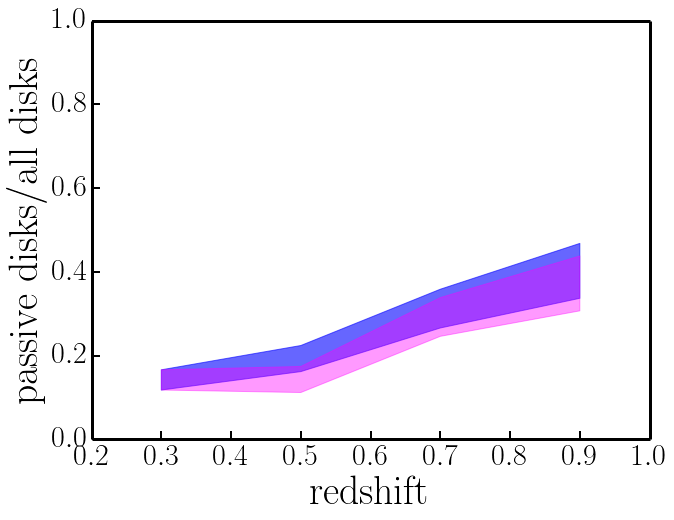

In [103]:
f=figure(figsize=(10,7.5))
alpha=.5
#plt.errorbar(reds,frac_c,yerr=(yl,yh),c='b',fmt='--o',lw=3,ms=5,label='corrected')
#plt.errorbar(reds,frac,yerr=(yl,yh),c='r',fmt='--o',lw=3,ms=5,label='corrected')
#plt.plot(reds,y1)
#plt.plot(reds,y2)
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30 
plt.tick_params(top='off',right='off')
plt.fill_between(reds,y1_c,y2_c,alpha=.6,color='#0000FF') #blue
plt.fill_between(reds,y1,y2,alpha=.4,color='#FF00FF') #pink


plt.xlabel('$\mathrm{redshift}$',fontsize=40)
plt.ylabel('$\mathrm{passive~disks/all~disks}$',fontsize=40)
plt.xlim(.2,1)
plt.ylim(0,1)
#columns = ('$0.2 < z < 0.4$', '$0.4 < z < 0.6$', '$0.6 < z < 0.8$', '$0.8 < z < 1.0$')
#rows = ['$\mathrm{passive~disks}$', '$\mathrm{all~disks}$', '$\mathrm{fraction}$']
#table_data=[Nr_c,Na_c,frac_c]
#the_table = plt.table(cellText=table_data,
                      #rowLabels=rows,
                      #colLabels=columns,
                      #loc=1)
#the_table.set_fontsize(50)
#the_table.scale(.6, 2)

plt.savefig('Poster_Images/red_disk_fraction_money_plot.png',format='png',dpi=1000)

In [110]:
yl_c


[0.022424331281545209,
 0.022526682745903137,
 0.028045153883638152,
 0.039071472938116303]

In [111]:
yh_c

[0.026041486556868915,
 0.024896346131916963,
 0.0295460372206936,
 0.0404040523955006]

In [119]:
.39+.04-(.12-.02)-.27

0.06

## Color-color plots

In [10]:
def Hist3D(xedges,yedges,the_data,colorhist):
    newmatrix = np.zeros(shape=(len(yedges)-1,len(xedges)-1))
    for i in range(0,len(yedges)-1):
        for j in range(0,len(xedges)-1):
            data_i_j = (the_data['MNUV']-the_data['MR']>=yedges[i]) & (the_data['MNUV']-the_data['MR'] < yedges[i+1]) & (the_data['MR']-the_data['MJ']>=xedges[j]) & (the_data['MR']-the_data['MJ']<xedges[j+1])
            newmatrix[i,j]=np.nanmean(the_data[data_i_j][p_edgeon])
    newmatrix=ma.masked_where(colorhist.T<10,newmatrix)
    return newmatrix

In [13]:
p_cut=.6
pec=(hubble_data[p_edgeon]<=p_cut) 
all_disks = SB_cut & (hubble_data['t01_smooth_or_features_a02_features_or_disk_best_fraction']>=disk_cut) & (hubble_data[z]>=xedges[0]) & (hubble_data[z] <= xedges[-1]) & (hubble_data[N_edge]>=5) 
red_disks = red_sequence & SB_cut & (hubble_data['t01_smooth_or_features_a02_features_or_disk_best_fraction']>=disk_cut) & (hubble_data[z]>=xedges[0]) & (hubble_data[z] <= xedges[-1]) & (hubble_data[N_edge]>=5)  
blue_disks = blue_cloud & SB_cut & (hubble_data['t01_smooth_or_features_a02_features_or_disk_best_fraction']>=disk_cut) & (hubble_data[z]>=xedges[0]) & (hubble_data[z] <= xedges[-1]) & (hubble_data[N_edge]>=5) 

#all disks
colorhist,xedge,yedge = np.histogram2d(hubble_data[all_disks]['MR']-hubble_data[all_disks]['MJ'],hubble_data[all_disks]['MNUV']-hubble_data[all_disks]['MR'],bins=(15,15))
extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]]
this_hist=Hist3D(xedge,yedge,hubble_data[all_disks],colorhist)

colorhist_contour,xedge_contour,yedge_contour = np.histogram2d(hubble_data[all_disks]['MR']-hubble_data[all_disks]['MJ'],hubble_data[all_disks]['MNUV']-hubble_data[all_disks]['MR'],bins=(20,20))
extent_contour=[xedge_contour[0],xedge_contour[-1],yedge_contour[0],yedge_contour[-1]]


N_passive = len(hubble_data[red_disks])
N_SF = len(hubble_data[all_disks]) - N_passive

#face-on disks
colorhist_pec,xedge_pec,yedge_pec = np.histogram2d(hubble_data[all_disks & pec]['MR']-hubble_data[all_disks & pec]['MJ'],hubble_data[all_disks & pec]['MNUV']-hubble_data[all_disks & pec]['MR'],bins=(15,15))
extent_pec=[xedge_pec[0],xedge_pec[-1],yedge_pec[0],yedge_pec[-1]]
this_hist_pec=Hist3D(xedge_pec,yedge_pec,hubble_data[all_disks & pec],colorhist_pec)

colorhist_contour_pec,xedge_contour_pec,yedge_contour_pec = np.histogram2d(hubble_data[all_disks & pec]['MR']-hubble_data[all_disks & pec]['MJ'],hubble_data[all_disks & pec]['MNUV']-hubble_data[all_disks & pec]['MR'],bins=(20,20))
extent_contour_pec=[xedge_contour_pec[0],xedge_contour_pec[-1],yedge_contour_pec[0],yedge_contour_pec[-1]]

N_passive_pec = len(hubble_data[red_disks & pec])
N_SF_pec = len(hubble_data[all_disks & pec]) - N_passive_pec



In [15]:
29-22

7

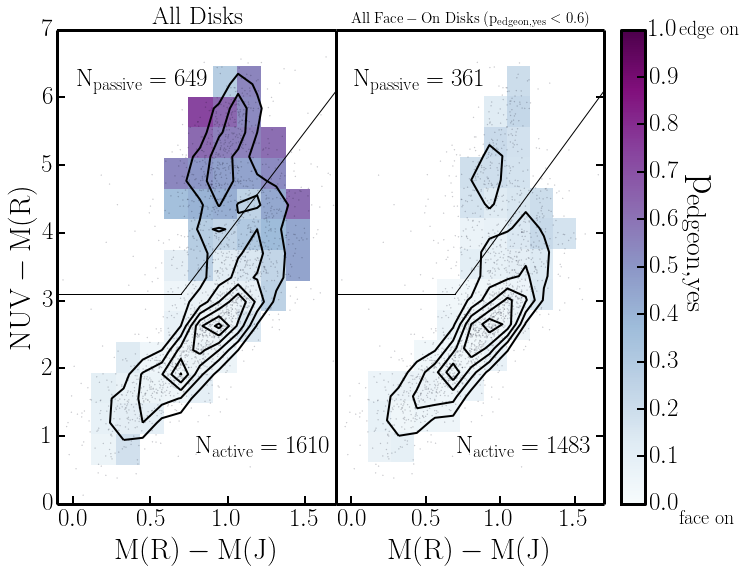

In [23]:
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25 

vmax=1

f=plt.figure(figsize=(11,8.5))
gs=gridspec.GridSpec(1,2,width_ratios=[1,1.2])
gs.update(wspace=0)


cmap=cm.BuPu
alpha=.3

x1=np.linspace(-5,.7,100)
x2=np.linspace(.7,5,100)


ax=plt.subplot(gs[0,0])


plt.scatter(hubble_data[all_disks]['MR']-hubble_data[all_disks]['MJ'],hubble_data[all_disks]['MNUV']-hubble_data[all_disks]['MR'],s=.1,alpha=alpha)
plt.contour(colorhist_contour.T,extent=extent,colors='k',linewidths=2)
plt.imshow(this_hist,origin='lower',extent=extent_contour,interpolation='nearest',cmap=cmap,vmin=0,vmax=vmax,aspect='auto')
plt.ylim(0,7)
plt.xlim(-.1,1.7)
plt.tick_params(top='off',right='off')

plt.ylabel('$\mathrm{NUV-M(R)}$',fontsize=30)
plt.xlabel('$\mathrm{M(R)-M(J)}$',fontsize=30)
plt.plot(x1,3.1+0*x1,c='k')
plt.plot(x2,3*x2+1,c='k')
plt.title('$\mathrm{All~Disks}$',fontsize=25)

ax=plt.subplot(gs[0,1])

plt.scatter(hubble_data[all_disks & pec]['MR']-hubble_data[all_disks & pec]['MJ'],hubble_data[all_disks & pec]['MNUV']-hubble_data[all_disks & pec]['MR'],s=.1,alpha=alpha)
plt.contour(colorhist_contour_pec.T,extent=extent_pec,colors='k',linewidths=2)
plt.imshow(this_hist_pec,origin='lower',extent=extent_contour_pec,interpolation='nearest',cmap=cmap,vmin=0,vmax=vmax,aspect='auto')
plt.ylim(0,7)
plt.xlim(-.1,1.7)
plt.xlabel('$\mathrm{M(R)-M(J)}$',fontsize=30)
plt.tick_params(labelleft='off',top='off',left='off')
plt.plot(x1,3.1+0*x1,c='k')
plt.plot(x2,3*x2+1,c='k')
plt.title('$\mathrm{All~Face-On~Disks~(p_{edgeon,yes}<%s)}$'%p_cut,fontsize=15)


plt.colorbar()
f.text(.91,.55,r'$\mathrm{p_{edgeon,yes}}$',rotation=270,fontsize=40,va='center')
f.text(.91,.1,r'$\mathrm{face~on}$',fontsize=20,va='center')
f.text(.91,.9,r'$\mathrm{edge~on}$',fontsize=20,va='center')

#numbers
f.text(.15,.8,r'$\mathrm{N_{passive}=%s}$'%N_passive,fontsize=25)
f.text(.3,.2,r'$\mathrm{N_{active}=%s}$'%N_SF,fontsize=25)

f.text(.5,.8,r'$\mathrm{N_{passive}=%s}$'%N_passive_pec,fontsize=25)
f.text(.63,.2,r'$\mathrm{N_{active}=%s}$'%N_SF_pec,fontsize=25)

plt.savefig('Poster_Images/red_sequence_selection.eps',format='eps',dpi=1000)



In [32]:
107./(107+673)

0.1371794871794872

In [66]:
#color-color plots
z_cut = (hubble_data[z]>=.2) & (hubble_data[z]<.4)

colorhist0,xedge0,yedge0 = np.histogram2d(hubble_data[all_disks & z_cut & pec]['MR']-hubble_data[all_disks & z_cut & pec]['MJ'],hubble_data[all_disks & z_cut & pec]['MNUV']-hubble_data[all_disks & z_cut & pec]['MR'],bins=(10,10))


In [67]:
def color_color(zl,zh):
    z_cut = (hubble_data[z]>=zl) & (hubble_data[z]<zh)
    colorhist,xedge,yedge = np.histogram2d(hubble_data[all_disks & z_cut & pec]['MR']-hubble_data[all_disks & z_cut & pec]['MJ'],hubble_data[all_disks & z_cut & pec]['MNUV']-hubble_data[all_disks & z_cut & pec]['MR'],bins=(10,10),range=[[xedge0[0],xedge0[-1]],[yedge0[0],yedge0[-1]]])
    colorhist_red,xedge_red,yedge_red = np.histogram2d(hubble_data[red_disks & z_cut & pec]['MR']-hubble_data[red_disks & z_cut & pec]['MJ'],hubble_data[red_disks & z_cut & pec]['MNUV']-hubble_data[red_disks & z_cut & pec]['MR'],bins=(10,10),range=[[xedge0[0],xedge0[-1]],[yedge0[0],yedge0[-1]]])

    N_disks=np.sum(colorhist)
    N_reds=np.sum(colorhist_red)
    N_sf=N_disks-N_reds
    colorhist = colorhist/N_disks
    extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]]

    colorhist_contour,xedge_contour,yedge_contour = np.histogram2d(hubble_data[all_disks & z_cut & pec]['MR']-hubble_data[all_disks & z_cut & pec]['MJ'],hubble_data[all_disks & z_cut & pec]['MNUV']-hubble_data[all_disks & z_cut & pec]['MR'],bins=(15,15))
    extent_contour=[xedge_contour[0],xedge_contour[-1],yedge_contour[0],yedge_contour[-1]]
    
    return colorhist, extent, colorhist_contour, extent_contour,N_reds,N_sf

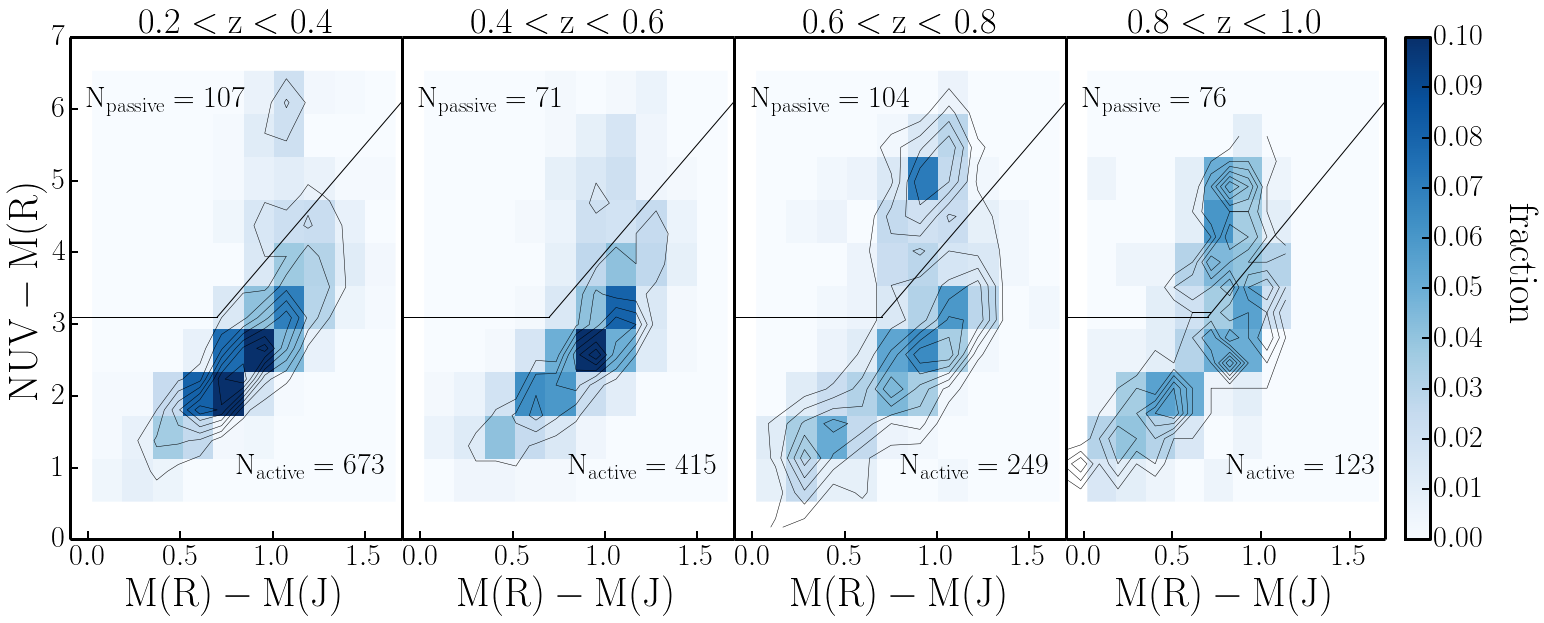

In [78]:
cmap=cm.Blues
alpha=.3

mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30 


x1=np.linspace(-5,.7,100)
x2=np.linspace(.7,5,100)

vmin=0
vmax=.1

red_list=[.2,.4,.6,.8,1.]

f=plt.figure(figsize=(25,9))
gs=gridspec.GridSpec(1,4,width_ratios=[1,1,1,1.2])
gs.update(wspace=0)

for i in range(0,4):
    ax=plt.subplot(gs[0,i])

    colorhist, extent, colorhist_contour, extent_contour,N_red,N_sf = color_color(red_list[i],red_list[i+1])
    plt.contour(colorhist_contour.T,extent=extent_contour,colors='k',linewidths=.5)
    plt.imshow(colorhist.T,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,aspect='auto',vmin=vmin,vmax=vmax)
    plt.ylim(0,7)
    plt.xlim(-.1,1.7)
    plt.plot(x1,3.1+0*x1,c='k')
    plt.plot(x2,3*x2+1,c='k')
    plt.title('$\mathrm{%s<z<%s}$'%(red_list[i],red_list[i+1]),fontsize=36)
    plt.tick_params(top='off')
    if i==0:
        plt.ylabel('$\mathrm{NUV-M(R)}$',fontsize=40)
        plt.tick_params(right='off')
    else:
        plt.tick_params(labelleft='off',left='off',right='off')
    plt.xlabel('$\mathrm{M(R)-M(J)}$',fontsize=40)
   
    if i==3:
        plt.colorbar()
    ax.annotate(r'$\mathrm{N_{passive}=%s}$'%int(N_red),fontsize=30,xy=(.05,.85),
            xycoords='axes fraction')
    ax.annotate(r'$\mathrm{N_{active}=%s}$'%int(N_sf),fontsize=30,xy=(.5,.12),
            xycoords='axes fraction')

f.text(.92,.55,r'$\mathrm{fraction}$',rotation=270,fontsize=40,va='center')

plt.savefig('Poster_Images/color_color_vs_redshift.eps',format='eps',dpi=1000)


In [127]:
#4 images

In [129]:
from PIL import Image
import urllib, cStringIO
def get_image_from_url(url):

    file = cStringIO.StringIO(urllib.urlopen(url).read())
    img = Image.open(file)
    return img
def galaxies_list_red(zl,zh):
    #get list of galaxies within certain ranges of z, mu and p_features 
    these_data=(hubble_data[z]>=zl) & (hubble_data[z] < zh) & red_disks
    return hubble_data[these_data]
def galaxies_list_blue(zl,zh):
    #get list of galaxies within certain ranges of z, mu and p_features 
    these_data=(hubble_data[z]>=zl) & (hubble_data[z] < zh) & blue_disks
    return hubble_data[these_data]

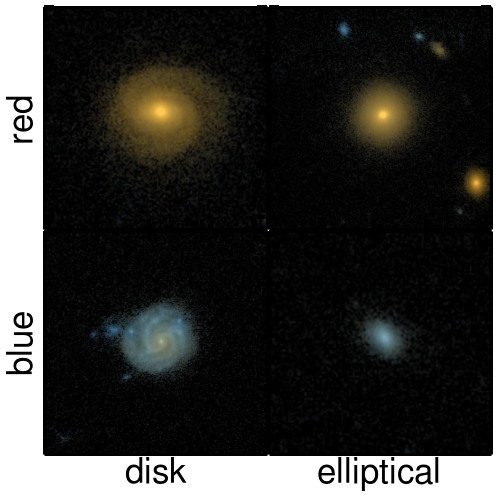

In [159]:
gs=gridspec.GridSpec(2,2)
gs.update(wspace=0.01)
gs.update(hspace=0.01)

red_disk=20025016
blue_disk=20089857
red_elliptical=20171226
blue_elliptical=20138257
blue_disk2=20005893
blue_disk3=20042631



#shuffle which galaxies get displayed     

f=plt.figure(figsize=(8,8))

#red disk
ax=plt.subplot(gs[0,0])

galaxy=(hubble_data['OBJNO_1']==red_disk)
gal = hubble_data[galaxy]

plt.imshow(get_image_from_url(gal['location'][0]))
plt.tick_params(labelbottom='off',labelleft='off')
plt.ylabel('red',fontsize=35)

#blue disk
ax=plt.subplot(gs[1,0])

galaxy=(hubble_data['OBJNO_1']==blue_disk)
gal = hubble_data[galaxy]

plt.imshow(get_image_from_url(gal['location'][0]))
plt.tick_params(labelbottom='off',labelleft='off')
plt.ylabel('blue',fontsize=35)
plt.xlabel('disk',fontsize=35)

#red elliptical
ax=plt.subplot(gs[0,1])

galaxy=(hubble_data['OBJNO_1']==red_elliptical)
gal = hubble_data[galaxy]

plt.imshow(get_image_from_url(gal['location'][0]))
plt.tick_params(labelbottom='off',labelleft='off')

#blue elliptical 
ax=plt.subplot(gs[1,1])

galaxy=(hubble_data['OBJNO_1']==blue_elliptical)
gal = hubble_data[galaxy]

plt.imshow(get_image_from_url(gal['location'][0]))
plt.tick_params(labelbottom='off',labelleft='off')
plt.xlabel('elliptical',fontsize=35)

    
    
    
plt.savefig('Poster_Images/gal_images.eps',format='eps',dpi=1000)


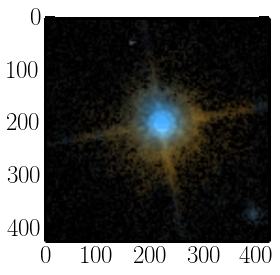

In [135]:
plt.imshow(get_image_from_url(hubble_data[0]['location']))


In [136]:
hubble_data[0]['location']

'http://zoo-hst.s3.amazonaws.com/20002220.jpg'

In [139]:
gal['location'][0]

'http://zoo-hst.s3.amazonaws.com/20002220.jpg'